#### Load library

In [1]:
from fmriprep_helpers import *
%matplotlib inline

### Single band vs. Multiband
We compare functional connectivity (FC) matrices estimated from single band acquisitions (N=34) and multiband acquisitions (N=100). We used data in CIFTI format registered to the MNI152NLin2009cAsym space, that were processed through fMRIPrep and denoised with rsDenoise with the strategy described in Finn et al., 2015. For each subject, two resting-state runs are concatenated before computing the average time series for each of 400 parcels of the Schaefer parcellation. FC is computed as the pair-wise Pearson's correlation between parcel time series. For subjects with more than one session, individual FC matrices are averaged across sessions. FC matrices are then averaged across subjects. We show the single band average FC in the lower triangular matric, and average multiband FC in the upper triangular matrix.

In [2]:
# Directory where parcellated time series are stored
FC_SB = 'data/FC_Conte_SB_cifti'
FC_MB = 'data/FC_Conte_MB_cifti'
FC_SB_raw = 'data/FC_Conte_SB_raw'
FC_MB_raw = 'data/FC_Conte_MB_raw'

# Define subject list, runs and sessions
subjects_SB = np.loadtxt('data/Conte_SB_list.txt',dtype=str,ndmin=1)
subjects_MB_rest = np.loadtxt('data/Conte_MB_list_complete_rest.txt',dtype=str,ndmin=1)
subjects_MB_movie = np.loadtxt('data/Conte_MB_list_complete_movie.txt',dtype=str,ndmin=1)

runs = ['task-rest_run-1','task-rest_run-2']

sessions_SB = ['ses-core1p1']
sessions_MB = ['ses-core1p2', 'ses-core1p3p0','ses-core1p3p1','ses-core2p2']

#### Compute FC matrices

Before denoising

In [7]:
#####
#  @brief Get FC matrices for list of subjects
#
#  @param [array-like] subjectList list of subject IDs
#  @param [array-like] runs list of runs
#  @param [array-like] sessions list of sessions (optional)
#  @param [str] parcellation parcellation name - needed if FCDir is None
#  @param [list] operations pipeline operations - needed if FCDir is None
#  @param [str] outputDir path to preprocessed data folder (optional, default is outpath())
#  @param [bool] isCifti True if preprocessed data is in cifti format
#  @param [str] fcMatFile full path to output file (default ./fcMats.mat)
#  @param [str] kind type of FC, one of {"correlation" (default), "partial correlation", "tangent", "covariance", "precision"}
#  @param [bool] overwrite True if existing files should be overwritten
#  @param [str] FCDir path to folder containing precomputed timeseries x parcels per subject - if None they are retrieved from each subject's folder
#  @param [bool] mergeSessions True if time series from different sessions should be merged before computing FC, otherwise FC from each session are averaged
#  @param [bool] mergeRuns True if time series from different runs should be merged before computing FC, otherwise FC from each run are averaged (if mergeSessions is True mergeRuns is ignored and everything is concatenated)
#  @param [CovarianceEstimator] cov_estimator if None, default sklearn.covariance.LedoitWolf estimator is used
#  @param [str] delimiter file delimiter in time series file. if None, defaults to ','
FC_SB_raw =  getAllFC(subjects_SB,runs,sessions_SB,isCifti=True,fcMatFile='data/FC_SB_raw.mat',kind='correlation',
                overwrite=True,FCDir=FC_SB_raw,mergeRuns=True,mergeSessions=False,delimiter=None)
FC_MB_raw =  getAllFC(subjects_MB_rest,runs,sessions_MB,isCifti=True,fcMatFile='data/FC_MB_raw.mat',kind='correlation',
                overwrite=True,FCDir=FC_MB_raw,mergeRuns=True,mergeSessions=False,delimiter=None)

After denoising

In [6]:
FC_SB =  getAllFC(subjects_SB,runs,sessions_SB,isCifti=True,fcMatFile='data/FC_SB.mat',kind='correlation',
                overwrite=True,FCDir=FC_SB,mergeRuns=True,mergeSessions=False,delimiter=None)
FC_MB =  getAllFC(subjects_MB_rest,runs,sessions_MB,isCifti=True,fcMatFile='data/FC_MB.mat',kind='correlation',
                overwrite=True,FCDir=FC_MB,mergeRuns=True,mergeSessions=False,delimiter=None)

#### Load precomputed FC matrices

In [278]:
FC_SB_raw = sio.loadmat('data/FC_SB_raw.mat')
FC_MB_raw = sio.loadmat('data/FC_MB_raw.mat')
FC_SB = sio.loadmat('data/FC_SB.mat')
FC_MB = sio.loadmat('data/FC_MB.mat')

#### Plot

In [10]:
square_fc_raw = np.zeros([400,400])
square_fc_raw[np.tril_indices(400,-1)] = FC_MB_raw['fcMats'].mean(axis=0)
square_fc_raw[np.triu_indices(400,1)] = square_fc_raw.T[np.triu_indices(400, 1)]
square_fc_raw[np.tril_indices(400,-1)] = FC_SB_raw['fcMats'].mean(axis=0)

In [11]:
square_fc = np.zeros([400,400])
square_fc[np.tril_indices(400,-1)] = FC_MB['fcMats'].mean(axis=0)
square_fc[np.triu_indices(400,1)] = square_fc.T[np.triu_indices(400, 1)]
square_fc[np.tril_indices(400,-1)] = FC_SB['fcMats'].mean(axis=0)

In [12]:
yeo_networks = np.hstack((
    np.repeat('visual',31),
    np.repeat('somatomotor',37),
    np.repeat('dorsal attention',23),
    np.repeat('ventral attention',22),
    np.repeat('limbic',13),
    np.repeat('frontoparietal',22),
    np.repeat('default',52),
    np.repeat('visual',31),
    np.repeat('somatomotor',37),
    np.repeat('dorsal attention',23),
    np.repeat('ventral attention',22),
    np.repeat('limbic',13),
    np.repeat('frontoparietal',22),
    np.repeat('default',52)
))

network_labels = pd.Series(yeo_networks)
network_labels.index = np.arange(400)
network_labels.name = 'networks'
sns.set_palette(palette='Paired',n_colors=network_labels.unique().size)
network_lut = dict(zip(map(str, network_labels.unique()), sns.color_palette(n_colors=network_labels.unique().size)))
network_colors = pd.Series(network_labels).map(network_lut)

In [13]:
sns.set(font_scale=1.4)

Before denoising

Text(652.0000000000001, 0.5, 'Multiband')

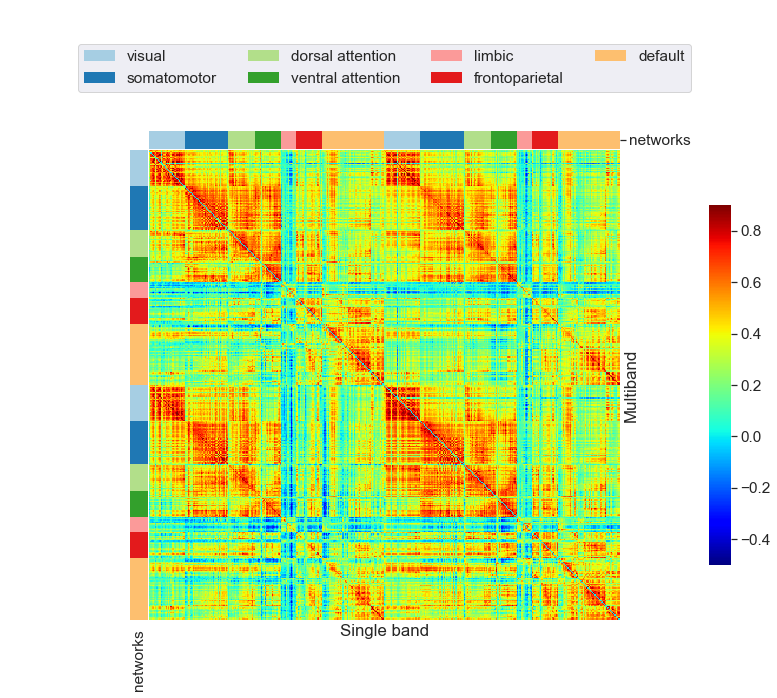

In [41]:
g = sns.clustermap(pd.DataFrame(square_fc_raw), cmap='jet',
                  # Turn off the clustering
                  row_cluster=False, col_cluster=False,
                  # Add colored class labels
                  row_colors=network_colors, col_colors=network_colors,
                  # Make the plot look better when many rows/cols
                  linewidths=0, xticklabels=False, yticklabels=False,vmin=-0.5,vmax=0.9)

_, idx = np.unique(network_labels, return_index=True)
legend = network_labels[np.sort(idx)]
for label in network_labels.unique():
    g.ax_col_dendrogram.bar(-1, 0, color=network_lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=4)
g.cax.set_position([1, 0.2, .03, .5])
ax = g.ax_heatmap
ax.set_xlabel('Single band')
ax.set_ylabel('Multiband')

In [15]:
g.savefig('FC_SB_vs_MB_raw.png', dpi=300, bbox_inches='tight')

After denoising

Text(652.0000000000001, 0.5, 'Multiband')

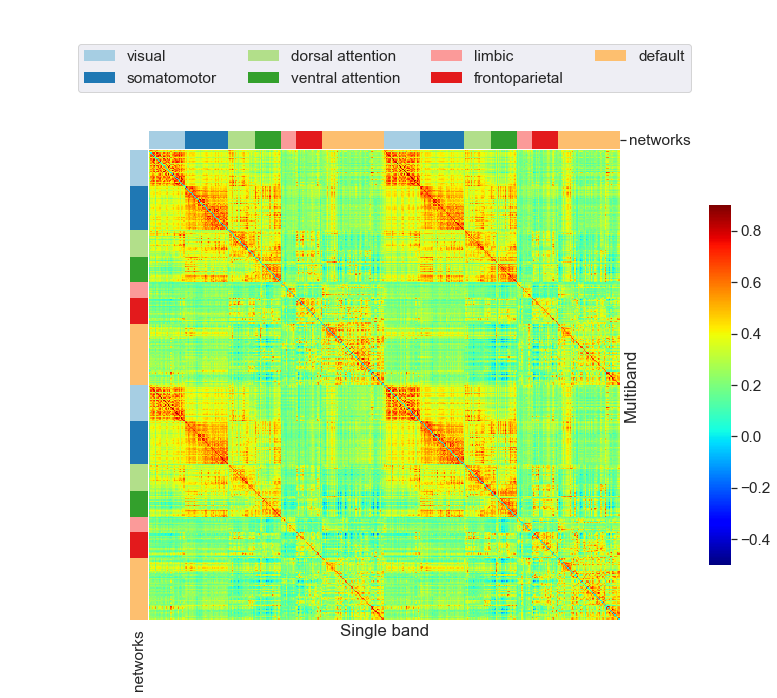

In [160]:
g = sns.clustermap(pd.DataFrame(square_fc), cmap='jet',
                  # Turn off the clustering
                  row_cluster=False, col_cluster=False,
                  # Add colored class labels
                  row_colors=network_colors, col_colors=network_colors,
                  # Make the plot look better when many rows/cols
                  linewidths=0, xticklabels=False, yticklabels=False,vmin=-0.5,vmax=0.9)

_, idx = np.unique(network_labels, return_index=True)
legend = network_labels[np.sort(idx)]
for label in network_labels.unique():
    g.ax_col_dendrogram.bar(-1, 0, color=network_lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=4)
g.cax.set_position([1, 0.2, .03, .5])
ax = g.ax_heatmap
ax.set_xlabel('Single band')
ax.set_ylabel('Multiband')

In [290]:
g.savefig('FC_SB_vs_MB.png', dpi=300, bbox_inches='tight')

### Movie-viewing vs. resting-state
We compare functional connectivity (FC) matrices estimated from movie-viewing fMRI (N=56) and resting-state fMRI scans (N=100), both acquired with multiband sequences. We used data in CIFTI format registered to the MNI152NLin2009cAsym space, that were processed through fMRIPrep and denoised with rsDenoise with the strategy described in Finn et al., 2015. For each subject, two movie-viewing runs (pixar + bang) are concatenated before computing the average time series for each of 400 parcels of the Schaefer parcellation. FC is computed as the pair-wise Pearson's correlation between parcel time series. For subjects with more than one session, individual FC matrices are averaged across sessions. FC matrices are then averaged across subjects. We show the single band average FC in the lower triangular matric, and average multiband FC in the upper triangular matrix.

In [96]:
# Directory where parcellated time series are stored
FC_MB_raw = 'data/FC_Conte_MB_raw'
FC_MB = 'data/FC_Conte_MB_cifti'

# Define subject list, runs and sessions
subjects_MB = np.loadtxt('data/Conte_MB_list_complete_rest.txt',dtype=str,ndmin=1)
subjects_movie = np.loadtxt('data/Conte_MB_list_complete_movie.txt',dtype=str,ndmin=1)

runs_movie = ['task-pixar_run-1','task-bang_run-1']
runs_rest = ['task-rest_run-1','task-rest_run-2']

sessions_MB = ['ses-core1p2', 'ses-core1p3p0','ses-core1p3p1','ses-core2p2']
sessions_movie = ['ses-core2p2']

#### Compute FC matrices

In [97]:
FC_movie_raw =  getAllFC(subjects_movie,runs_movie,sessions_movie,isCifti=True,fcMatFile='data/FC_movie_raw.mat',kind='correlation',
                overwrite=True,FCDir=FC_MB_raw,mergeRuns=True,mergeSessions=False)
FC_rest_raw =  getAllFC(subjects_MB,runs_rest,sessions_MB,isCifti=True,fcMatFile='data/FC_rest_raw.mat',kind='correlation',
                overwrite=True,FCDir=FC_MB_raw,mergeRuns=True,mergeSessions=False)
FC_movie =  getAllFC(subjects_movie,runs_movie,sessions_movie,isCifti=True,fcMatFile='data/FC_movie.mat',kind='correlation',
                overwrite=True,FCDir=FC_MB,mergeRuns=True,mergeSessions=False)
FC_rest =  getAllFC(subjects_MB,runs_rest,sessions_MB,isCifti=True,fcMatFile='data/FC_rest.mat',kind='correlation',
                overwrite=True,FCDir=FC_MB,mergeRuns=True,mergeSessions=False)

or load them

In [298]:
FC_movie_raw = sio.loadmat('data/FC_movie_raw.mat')
FC_rest_raw = sio.loadmat('data/FC_rest_raw.mat')
FC_movie = sio.loadmat('data/FC_movie.mat')
FC_rest = sio.loadmat('data/FC_rest.mat')

#### Plot

In [299]:
square_fc_raw = np.zeros([400,400])
square_fc_raw[np.tril_indices(400,-1)] = FC_rest_raw['fcMats'].mean(axis=0)
square_fc_raw[np.triu_indices(400,1)] = square_fc_raw.T[np.triu_indices(400, 1)]
square_fc_raw[np.tril_indices(400,-1)] = FC_movie_raw['fcMats'].mean(axis=0)

In [300]:
square_fc = np.zeros([400,400])
square_fc[np.tril_indices(400,-1)] = FC_rest['fcMats'].mean(axis=0)
square_fc[np.triu_indices(400,1)] = square_fc.T[np.triu_indices(400, 1)]
square_fc[np.tril_indices(400,-1)] = FC_movie['fcMats'].mean(axis=0)

In [56]:
yeo_networks = np.hstack((
    np.repeat('visual',31),
    np.repeat('somatomotor',37),
    np.repeat('dorsal attention',23),
    np.repeat('ventral attention',22),
    np.repeat('limbic',13),
    np.repeat('frontoparietal',22),
    np.repeat('default',52),
    np.repeat('visual',31),
    np.repeat('somatomotor',37),
    np.repeat('dorsal attention',23),
    np.repeat('ventral attention',22),
    np.repeat('limbic',13),
    np.repeat('frontoparietal',22),
    np.repeat('default',52)
))

network_labels = pd.Series(yeo_networks)
network_labels.index = np.arange(400)
network_labels.name = 'networks'
sns.set_palette(palette='Paired',n_colors=network_labels.unique().size)
network_lut = dict(zip(map(str, network_labels.unique()), sns.color_palette(n_colors=network_labels.unique().size)))
network_colors = pd.Series(network_labels).map(network_lut)

In [260]:
sns.set(font_scale=1.8)

Before denoising

Text(652.0000000000001, 0.5, 'Resting state')

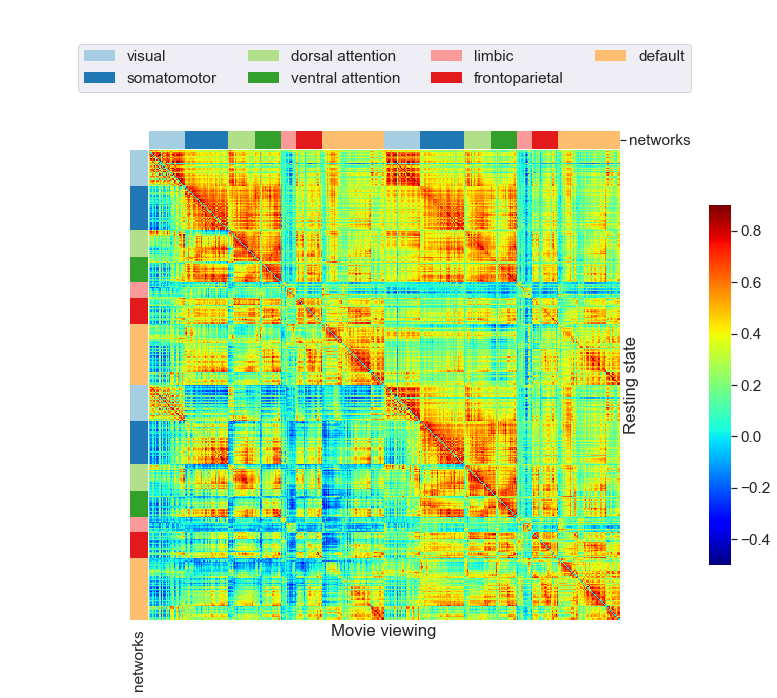

In [143]:
g = sns.clustermap(pd.DataFrame(square_fc_raw), cmap='jet',
                  # Turn off the clustering
                  row_cluster=False, col_cluster=False,
                  # Add colored class labels
                  row_colors=network_colors, col_colors=network_colors,
                  # Make the plot look better when many rows/cols
                  linewidths=0, xticklabels=False, yticklabels=False,vmin=-0.5,vmax=0.9)

_, idx = np.unique(network_labels, return_index=True)
legend = network_labels[np.sort(idx)]
for label in network_labels.unique():
    g.ax_col_dendrogram.bar(-1, 0, color=network_lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=4)
g.cax.set_position([1, 0.2, .03, .5])
ax = g.ax_heatmap
ax.set_xlabel('Movie viewing')
ax.set_ylabel('Resting state')

In [302]:
g.savefig('FC_movie_vs_rest_raw.png', dpi=300, bbox_inches='tight')

After denoising

Text(652.0000000000001, 0.5, 'Resting state')

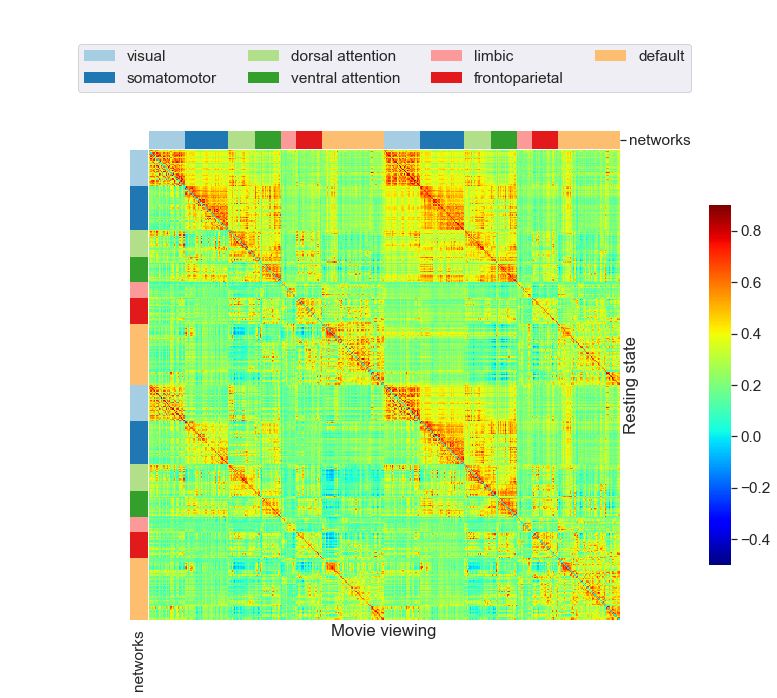

In [146]:
g = sns.clustermap(pd.DataFrame(square_fc), cmap='jet',
                  # Turn off the clustering
                  row_cluster=False, col_cluster=False,
                  # Add colored class labels
                  row_colors=network_colors, col_colors=network_colors,
                  # Make the plot look better when many rows/cols
                  linewidths=0, xticklabels=False, yticklabels=False,vmin=-0.5,vmax=0.9)

_, idx = np.unique(network_labels, return_index=True)
legend = network_labels[np.sort(idx)]
for label in network_labels.unique():
    g.ax_col_dendrogram.bar(-1, 0, color=network_lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=4)
g.cax.set_position([1, 0.2, .03, .5])
ax = g.ax_heatmap
ax.set_xlabel('Movie viewing')
ax.set_ylabel('Resting state')

In [297]:
g.savefig('FC_movie_vs_rest.png', dpi=300, bbox_inches='tight')